In [1]:
import cv2, os, glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [13]:
# 記事図面では省略(カメラキャリブレーション用の関数定義)

CHESSBOARD_SIZE = ( 9, 6 )   # チェスボード撮影
objp = np.zeros( (1, CHESSBOARD_SIZE[0] * CHESSBOARD_SIZE[1], 3 ), np.float32 )
objp[ 0, :, :2 ] = np.mgrid[ 0:CHESSBOARD_SIZE[0], 0:CHESSBOARD_SIZE[1] ].T.reshape( -1, 2 )

criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
calib_flags_f = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv2.fisheye.CALIB_CHECK_COND + cv2.fisheye.CALIB_FIX_SKEW

def findCorners( imgDir, side ): # ディレクトリ内画像から格子点抽出
    imgPaths = sorted(glob.glob( imgDir + '*png' ) )
    img_size = None; objpoints = []; imgpoints = [] 
    for imgPath in sorted( imgPaths ):
        img = cv2.imread( imgPath )
        if side == 'LEFT':        
            img = img[ :int( img.shape[0]/2 ), :, : ]
        if side == 'RIGHT':
            img = img[ int( img.shape[0]/2 ):, :, : ]
        if img_size == None:
            img_size = img.shape[ :2 ]
        gray = cv2.cvtColor( img,cv2.COLOR_BGR2GRAY )
        ret, corners = cv2.findChessboardCorners(gray, CHESSBOARD_SIZE, 
                cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+
                                                 cv2.CALIB_CB_NORMALIZE_IMAGE)
        if ret: # さらにサブピクセルの位置推定をする
            objpoints.append( objp )
            cornersM = cv2.cornerSubPix( gray, corners, ( 5, 5 ), ( -1,-1 ), criteria )
            imgpoints.append( cornersM )  
    return objpoints, imgpoints, img_size, gray

def calibrate(objpoints, imgpoints, img_size, cameramodel ):
    img_number = len( objpoints ) #number of the pictures
    K = np.zeros( ( 3, 3 ) )
    D = np.zeros( ( 4, 1 ) )
    rvecs = [ np.zeros( ( 1, 1, 3 ), dtype=np.float64 ) for i in range( img_number ) ]
    tvecs = [ np.zeros( ( 1, 1, 3 ), dtype=np.float64 ) for i in range( img_number ) ]
    if  cameramodel == 'FISHEYE': # Fisheyeカメラとしてキャリブレーション
        rms, K, D, r, t = cv2.fisheye.calibrate( objpoints, imgpoints, img_size[ ::-1 ],
                                K, D, rvecs, tvecs, calib_flags_f,
        (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6) )
    else:  # ノーマルカメラとしてキャリブレーション
        rms, K, D, r, t = cv2.calibrateCamera( objpoints, imgpoints, img_size[ ::-1 ], None, None )
    dimension = img_size[::-1]
    return  dimension , K , D


In [15]:
# Raw画像を1200x2400にした画像群から左カメラ
# Raw画像を1200x2400にした画像群から右カメラ

objpointsL, imgpointsL, img_sizeL, grayL = findCorners( 'PNGsmall/', 'LEFT' )
dimensionL, KL , DL =  calibrate( objpointsL, imgpointsL, img_sizeL, 'FISHEYE' )

objpointsR, imgpointsR, img_sizeR, grayR = findCorners( 'PNGsmall/', 'RIGHT' )
dimensionR, KR, DR =  calibrate( objpointsR, imgpointsR, img_sizeR, 'FISHEYE' )

In [18]:
# 記事図面では省略

# ノーマルカメラモデルでstereocalibrationするために、
# fisheyeカメラモデルでundistorted したイメージを保存
def undistorted(img, K, D, DIM): # 歪み除去
    map1, map2 = cv2.fisheye.initUndistortRectifyMap( K, D, np.eye(3), K, DIM, cv2.CV_16SC2 ) 
    undistortedImg = cv2.remap( img, map1, map2,  interpolation=cv2.INTER_LINEAR, 
                               borderMode=cv2.BORDER_TRANSPARENT,  borderValue=29 )
    return undistortedImg

def undistortInDir( imgDir  ):  # チェスボード撮影画像の歪み除去
    imgPaths = sorted( glob.glob( imgDir + '*png' ) )
    img_size = None; objpoints = []; imgpoints = [] 
    for imgPath in sorted( imgPaths ):  # 左右画像を読み込む
        aimg = cv2.imread( imgPath )
        imgL = aimg[ :int( aimg.shape[0] / 2), :, : ]
        imgR = aimg[ int( aimg.shape[0] / 2):, :, : ]
        cv2.imwrite( imgPath + '.left.png', undistorted( imgL, KL, DL, dimensionL ) ) 
        cv2.imwrite( imgPath + '.right.png', undistorted( imgR, KR, DR, dimensionR ) )

In [19]:
undistortInDir( 'PNGsmall/' )
# PNGsmallディレクトリに、*.right.png, *left.pngができるので、それぞれ　undistorted/right/, undistorted/left/ ディレクトリに移動しておく

In [20]:
# undistort済み画像から、左右のカメラパラメータを設定
# ディレクトリからundistortedな左画像群を読み込み、

objpointsL, imgpointsL, img_sizeL, grayL = findCorners('undistorted/left/', 'SINGLE' )
dumyDim, KLu , DLu =  calibrate( objpointsL, imgpointsL, img_sizeL, 'NORMAL' )

objpointsR, imgpointsR, img_sizeR, grayR = findCorners('undistorted/right/', 'SINGLE' )
dumyDim, KRu, DRu =  calibrate( objpointsR, imgpointsR, img_sizeR, 'NORMAL' )

#print( KLu ); print( DLu );      print( KRu ); print( DRu ) 

In [21]:
# 記事図面では省略

# ノーマルカメラモデルでステレオキャリブレーションするために
# fisheye カメラでundistortされた
# 左右画像が入ったディレクトリパスを渡されたら、左右画像から
# 「左右ともに検出された」チェッカーボードの格子点情報を返す
def findStereoPoints( leftDir, rightDir ):
    leftPaths = sorted( glob.glob( leftDir + '*.left.png' ) )
    rightPaths = sorted( glob.glob( rightDir + '*.right.png' ) )
    objpoints = [];   imgpointsL = []; imgpointsR = [] 
    for i  in range( len( leftPaths ) ):
        grayL = cv2.cvtColor( cv2.imread( leftPaths[ i ] ), cv2.COLOR_BGR2GRAY )
        grayR = cv2.cvtColor( cv2.imread( rightPaths[ i ] ), cv2.COLOR_BGR2GRAY )
        # 左右の各撮影からチェッカーボードの格子点位置を抽出する
        retL, cornersL = cv2.findChessboardCorners( grayL, CHESSBOARD_SIZE, 
            cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK
                                                   +cv2.CALIB_CB_NORMALIZE_IMAGE )
        retR, cornersR = cv2.findChessboardCorners( grayR, CHESSBOARD_SIZE, 
            cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK
                                                   +cv2.CALIB_CB_NORMALIZE_IMAGE )
        if retL and retR: # 共に検出を終えたら、さらにサブピクセルの位置推定をする
            objpoints.append( objp )
            cornersML = cv2.cornerSubPix( grayL, cornersL, (5, 5), (-1,-1), criteria )
            cornersMR = cv2.cornerSubPix( grayR, cornersR, (5, 5), (-1,-1), criteria )
            imgpointsL.append( cornersML.reshape(-1, 2) )
            imgpointsR.append( cornersMR.reshape(-1, 2) )            
    return objpoints, imgpointsL, imgpointsR

In [22]:
# チェッカーボードの格子点座標と左右撮影画像の対応点を読み込む
objpoints, imgpointsL, imgpointsR = findStereoPoints(
    'undistorted/left/',
    'undistorted/right/' )

# ステレオカメラの幾何関係を推定
R = np.zeros( ( 1, 1, 3), dtype=np.float64 )
T = np.zeros( ( 1, 1, 3), dtype=np.float64 )
rms, K1, D1, K2, D, r, t, e, f =  cv2.stereoCalibrate(
        objpoints, imgpointsL, imgpointsR,
        KLu, DLu, KRu, DRu, img_sizeL, R, T, calib_flags_f,
        (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 
         10000, 1.0) )

# print( [ rms, K1, D1, K2, D, r, t, e, f ] )

In [23]:
# チェッカーボードの格子点座標と左右撮影画像の対応点を読み込む
objpoints, imgpointsL, imgpointsR = findStereoPoints( 
    './undistorted/left/',  './undistorted/right/' )
# ステレオカメラの幾何関係を推定
R = np.zeros( ( 1, 1, 3), dtype=np.float64 )
T = np.zeros( ( 1, 1, 3), dtype=np.float64 )
rms, K1, D1, K2, D, r, t, e, f =  cv2.stereoCalibrate(
        objpoints, imgpointsL, imgpointsR,
        KLu, DLu, KRu, DRu, img_sizeL, R, T, calib_flags_f,
        (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 
         10000, 1.0) )

In [24]:
# 撮影画像（1200x2400）を読み込んで、歪み除去する
def separateAndUndistort( imgPath, KL, DL, KR, DR, imageShape ):
    img = cv2.imread( imgPath )
    ulimg =  undistorted( img[ :int( img.shape[0]/2), :, : ], KL, DL, imageShape )
    urimg =  undistorted( img[ int( img.shape[0]/2):, :, : ], KR, DR, imageShape )
    return ulimg, urimg

ulimg, urimg = separateAndUndistort( 'IMG_20190506_153518_00_008.png',  KL, DL, KR, DR, img_sizeL )

# tourist
#ulimg, urimg = separateAndUndistort( 'IMG_20190505_073905_00_026.png',  KL, DL, KR, DR, img_sizeL )
# bangkon statue
#ulimg, urimg = separateAndUndistort( 'IMG_20190506_161300_00_028.png',  KL, DL, KR, DR, img_sizeL )

# 宮殿
#ulimg, urimg = separateAndUndistort( 'IMG_20190506_153518_00_008.png',  KL, DL, KR, DR, img_sizeL )

#ulimg, urimg = separateAndUndistort( 'IMG_20190424_195746_00_001s.png',  KL, DL, KR, DR, img_sizeL )

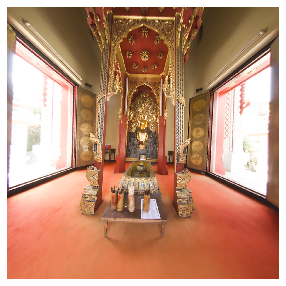

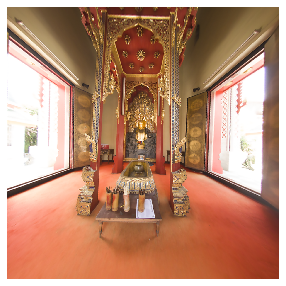

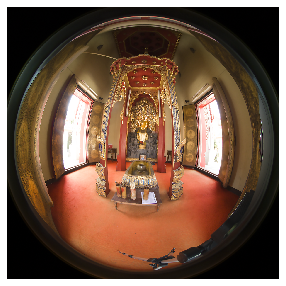

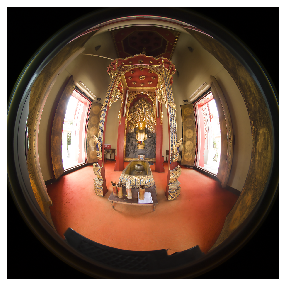

In [25]:
img = cv2.imread( 'IMG_20190506_153518_00_008.png' )

cv2.imwrite("sL.png",img[ :int( img.shape[0]/2), :, : ])
cv2.imwrite("sR.png", img[ int( img.shape[0]/2):, :, : ])

cv2.imwrite("ulimg.png", ulimg )
cv2.imwrite("urimg.png", urimg )

plt.figure(figsize=(5, 5)); plt.axis("off")
plt.imshow( cv2.cvtColor(ulimg, cv2.COLOR_BGR2RGB) )
plt.figure(figsize=(5, 5)); plt.axis("off")
plt.imshow( cv2.cvtColor( urimg, cv2.COLOR_BGR2RGB) )

plt.figure(figsize=(5, 5)); plt.axis("off")
plt.imshow( cv2.cvtColor(img[ :int( img.shape[0]/2), :, : ], cv2.COLOR_BGR2RGB) )
plt.figure(figsize=(5, 5)); plt.axis("off")
plt.imshow( cv2.cvtColor( img[ int( img.shape[0]/2):, :, : ], cv2.COLOR_BGR2RGB) )

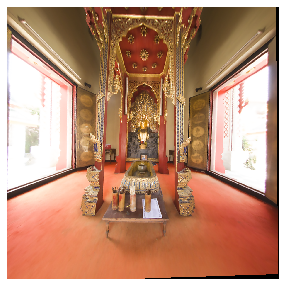

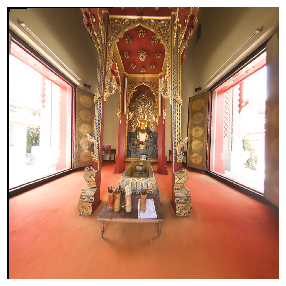

In [26]:
# 平行化変換マトリクスや透視投影変換行列を算出
flags = 0; alpha = 1; 
R1, R2, P1, P2, Q, validPixROI1, validPixROI2 = cv2.stereoRectify(
    KLu, DLu, KRu, DRu, img_sizeL[ ::-1 ], 
    r, t,  flags, alpha, img_sizeL[ ::-1 ] )
# 平行化変換マトリクスから平行化変換マップを作る
map1_l, map2_l = cv2.initUndistortRectifyMap(  # 左画像
    KLu, DLu, R1, P1, img_sizeL[ ::-1 ], cv2.CV_32FC1)
map1_r, map2_r = cv2.initUndistortRectifyMap( # 右画像
    KRu, DRu, R2, P2, img_sizeL[ ::-1 ], cv2.CV_32FC1)
# 変換マップを使い平行化
interpolation = cv2.INTER_NEAREST
Re_TgtImg_l = cv2.remap( ulimg, map1_l, map2_l, interpolation )
Re_TgtImg_r = cv2.remap( urimg, map1_r, map2_r, interpolation )


cv2.imwrite("Re_TgtImg_l.png", Re_TgtImg_l )
cv2.imwrite("Re_TgtImg_r.png", Re_TgtImg_r )


# 変換された画像を表示
plt.figure(figsize=(5, 5)); plt.axis("off")
plt.imshow( cv2.cvtColor(Re_TgtImg_l, cv2.COLOR_BGR2RGB) )
plt.figure(figsize=(5, 5)); plt.axis("off")
plt.imshow( cv2.cvtColor(Re_TgtImg_r, cv2.COLOR_BGR2RGB) )

True

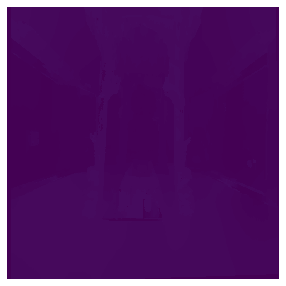

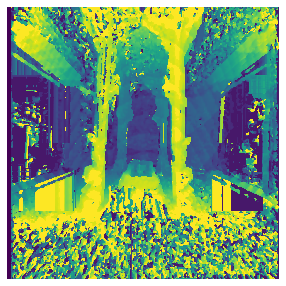

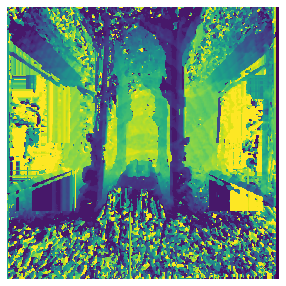

In [27]:
# 視差マップを生成する

window_size = 0  # 1,3
left_matcher = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=16,  # 視差探索最大値(16の倍数）
    blockSize=11,#11,  # (ブロックマッチングのサイズ-1)/2  5以上が必要
    # disparity の滑らかさ
    P1=8 * 3 * window_size ** 2,    # wsize default 3; 5; 7 for SGBM reduced size image; 15 for SGBM full size image (1300px and above); 5 Works nicely
    P2=32 * 3 * window_size ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=10, # 5-15
    speckleWindowSize=0, # 0
    speckleRange=1,  # 2
    preFilterCap=63,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)
right_matcher = cv2.ximgproc.createRightMatcher( left_matcher )

# FILTER Parameters
lmbda = 20000;   #80000
sigma = 1.2;  #1.2
visual_multiplier = 1.0 #1.0
wls_filter = cv2.ximgproc.createDisparityWLSFilter(
    matcher_left=left_matcher )
wls_filter.setLambda( lmbda )
wls_filter.setSigmaColor( sigma )

# 視差を計算する
displ = left_matcher.compute( Re_TgtImg_l, Re_TgtImg_r ).astype(np.float32)
dispr = right_matcher.compute( Re_TgtImg_r, Re_TgtImg_l ).astype(np.float32)
filteredDisp = wls_filter.filter( displ, Re_TgtImg_l, None, dispr )


# 距離マップを表示（この部分は記事では不要か）
filteredDisp = cv2.normalize(src=filteredDisp, dst=filteredDisp, 
        beta=0, alpha=255, norm_type=cv2.NORM_MINMAX);

plt.figure(figsize=(5, 5)); plt.axis("off"); plt.imshow( filteredDisp )

plt.figure(figsize=(5, 5)); plt.axis("off"); plt.imshow( displ )
plt.figure(figsize=(5, 5)); plt.axis("off"); plt.imshow( dispr )

cv2.imwrite( 'imgL.png', Re_TgtImg_l )
cv2.imwrite( 'filteredDisp.png', filteredDisp )

True

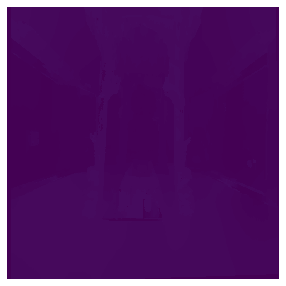

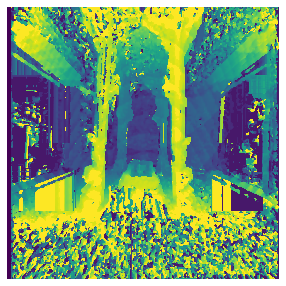

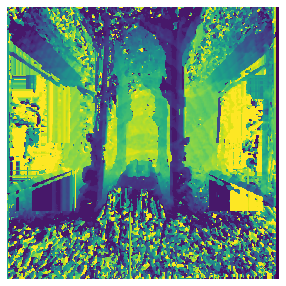

In [28]:
window_size = 0
left_matcher = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=16,  # 視差探索最大値(16の倍数）
    blockSize=11, #ブロックマッチング・サイズ
    P1=8 * 3 * window_size ** 2, P2=32 * 3 * window_size ** 2,
    disp12MaxDiff=1, uniquenessRatio=10,
    speckleWindowSize=0, speckleRange=1,
    preFilterCap=63, mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
);  right_matcher = cv2.ximgproc.createRightMatcher( left_matcher )

lmbda = 20000; sigma = 1.2; visual_multiplier = 1.0
wls_filter = cv2.ximgproc.createDisparityWLSFilter(
                    matcher_left=left_matcher )
wls_filter.setLambda( lmbda ); wls_filter.setSigmaColor( sigma )

# 視差を計算する
displ = left_matcher.compute( Re_TgtImg_l, Re_TgtImg_r ).astype(np.float32)
dispr = right_matcher.compute( Re_TgtImg_r, Re_TgtImg_l ).astype(np.float32)
filteredDisp = wls_filter.filter( displ, Re_TgtImg_l, None, dispr )

# 距離マップを表示（この部分は記事では不要）
#filteredDisp = cv2.normalize(src=filteredDisp, dst=filteredDisp, 
#        beta=0, alpha=255, norm_type=cv2.NORM_MINMAX);

plt.figure(figsize=(5, 5)); plt.axis("off"); plt.imshow( filteredDisp )

plt.figure(figsize=(5, 5)); plt.axis("off"); plt.imshow( displ )
plt.figure(figsize=(5, 5)); plt.axis("off"); plt.imshow( dispr )

cv2.imwrite( 'imgL.png', Re_TgtImg_l )

cv2.imwrite( 'filteredDisp.png', filteredDisp )

In [29]:
# 記事図面では省略

import numpy
import pylab as plt

ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''

# ply形式の3Dモデルファイルを生成
def write_ply( filePath, verts, colors ):
    verts = verts.reshape( -1, 3 )
    colors = colors.reshape( -1, 3 )
    verts = numpy.hstack( [ verts, colors ] )
    with open( filePath, 'w' ) as f:
        f.write( ply_header % dict( vert_num = len( verts ) ) )
        numpy.savetxt( f, verts,"%f %f %f %d %d %d" )

def bgr2rbg(im):  # （使っていない）
    b, g, r = cv2.split( im )
    im = cv2.merge([r,g,b])
    return im

# 結果の表示 (使っていない)
def show_result(im_l,im_r,disp):
    graph = plt.figure()
    plt.rcParams["font.size"]=15
    # 左画像
    plt.subplot(2,2,1),plt.imshow(bgr2rbg(im_l))
    plt.title("Left Image")
    # 右画像
    plt.subplot(2,2,2),plt.imshow(bgr2rbg(im_r))
    plt.title("Right Image")
    # 視差画像
    plt.subplot(2,2,3),plt.imshow(disp,"gray")
    plt.title("Disparity")
    plt.show()

In [31]:
# 視差画像から、透視投影変換行列を使って、x,y,z座標＆色点群を生成
pts = cv2.reprojectImageTo3D( filteredDisp/16.0, Q )
rgbs = cv2.cvtColor( Re_TgtImg_l, cv2.COLOR_BGR2RGB )
mask = filteredDisp/16.0 > 1
out_points = pts[ mask ]; out_colors = rgbs[ mask ]
write_ply( "colorL.ply", out_points, out_colors )   # 左視点色で点群保存
rgbs2 = cv2.cvtColor( Re_TgtImg_r, cv2.COLOR_BGR2RGB )
out_colors2 = rgbs2[ mask ]
write_ply( "colorR.ply", out_points, out_colors2 ) # 右視点色で点群保存

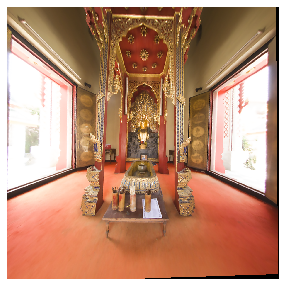

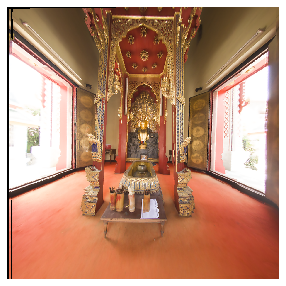

In [32]:
# disparity map を使い、右画像を左画像画素に対応づけるための
# index mapを作成する。

x = np.array( [ x for x in range( ulimg.shape[1] ) ] )
y = np.array( [ y for y in range( ulimg.shape[0] ) ]  )
idx_x, idx_y = np.meshgrid( x, y ) 
idx_x_r = cv2.remap( idx_x, idx_x.astype(np.float32)-filteredDisp/16.0, 
                    idx_y.astype(np.float32) , interpolation )
Re_TgtImg_r2 = cv2.remap( Re_TgtImg_r, idx_x_r.astype(np.float32), 
                         idx_y.astype(np.float32) , interpolation )
cv2.imwrite('ImageR2.png', Re_TgtImg_r2)
cv2.imwrite('ImageL2.png', Re_TgtImg_l)

# 変換された画像を表示
plt.figure(figsize=(5, 5)); plt.axis("off")
plt.imshow( cv2.cvtColor(Re_TgtImg_l, cv2.COLOR_BGR2RGB) )
plt.figure(figsize=(5, 5)); plt.axis("off")
plt.imshow( cv2.cvtColor(Re_TgtImg_r2, cv2.COLOR_BGR2RGB) )